In [2]:
import numpy as np 
import pandas as pd
from hmmlearn import hmm

from matplotlib import pyplot as plt
import seaborn as sbn
from matplotlib.patches import Ellipse

import umap

# Overview 


HMM using [this](https://hmmlearn.readthedocs.io/en/latest/) package. 

In [3]:
clover = pd.read_csv('../data/HEK8/clover_all_cell.csv')
clo_ren = {x:f'clo_{x}' for x in clover.columns[1:-3]}
clover = clover.rename(clo_ren, axis=1)
clo_sel = [x for x in clover.columns[1:-3]]
mscarlet = pd.read_csv('../data/HEK8/mscarlet_all_cell.csv')
msc_ren = {x:f'msc_{x}' for x in mscarlet.columns[1:-3]}
mscarlet = mscarlet.rename(msc_ren, axis=1)
msc_sel = [x for x in mscarlet.columns[1:-3]]
dat = clover.merge(mscarlet, on=['track_index', 'cell__treatment'])
dat.head()

,track_index,clo_0.0,clo_0.2,clo_0.5,clo_0.8,clo_1.0,clo_1.2,clo_1.5,clo_1.8,clo_2.0,...,msc_20.0,msc_20.2,msc_20.5,msc_20.8,msc_21.0,msc_21.2,msc_21.5,msc_site,median_y,start_y
0,81_1000189001_heya8_cdk2_mdmx__untreated,0.996649,0.995112,0.993575,0.992038,0.990501,0.969413,0.948325,0.927237,0.906149,...,0.251737,0.265279,0.192591,0.244134,0.082932,0.263016,0.209343,81,0.145431,0.124073
1,86_1000215388_heya8_cdk2_mdmx__untreated,0.995417,0.295146,0.366373,0.333625,0.412077,0.411844,0.423543,0.397102,0.861592,...,0.182044,0.377607,0.418803,0.414202,0.363932,0.313662,0.263392,86,0.230868,0.427603
2,83_1000195542_heya8_cdk2_mdmx__untreated,0.994308,0.968303,0.904938,0.900423,0.922883,0.859205,0.940154,0.887254,0.834353,...,0.315201,0.230373,0.143581,0.154162,0.149599,0.173044,0.320218,83,0.144564,0.264669
3,73_1000149946_heya8_cdk2_mdmx__untreated,0.988188,0.992811,0.982868,0.972926,0.962983,0.951770,0.967916,0.831321,0.856759,...,0.317119,0.247422,0.177726,0.108029,0.038332,0.059854,0.045033,73,0.130409,0.027369
4,81_1000187465_heya8_cdk2_mdmx__untreated,0.967397,0.728514,0.911879,0.567794,0.528236,0.560685,0.857484,0.982574,0.896957,...,0.166773,0.066651,0.210760,0.169529,0.123079,0.168578,0.314991,81,0.169868,0.580908


In [5]:
data = pd.read_csv('../data/aggregated_data.csv', low_memory=False)
data.head()

,track_index,cell__treatment,median,time(h),pathway_score,color,dataset,cell_line,pathway_1,pathway_2,inhibitor,conc
0,82_1000111247_k562_erk_akt__untreated,k562_erk_akt__untreated,0.890648,0.0,0.699047,clover,H190923,k562,erk,akt,untreated,NaN
1,82_1000111247_k562_erk_akt__untreated,k562_erk_akt__untreated,0.890648,0.2,0.860223,clover,H190923,k562,erk,akt,untreated,NaN
2,82_1000111247_k562_erk_akt__untreated,k562_erk_akt__untreated,0.890648,0.5,0.833703,clover,H190923,k562,erk,akt,untreated,NaN
3,82_1000111247_k562_erk_akt__untreated,k562_erk_akt__untreated,0.890648,0.8,0.876799,clover,H190923,k562,erk,akt,untreated,NaN
4,82_1000111247_k562_erk_akt__untreated,k562_erk_akt__untreated,0.890648,1.0,0.744755,clover,H190923,k562,erk,akt,untreated,NaN


In [8]:
len(clo_sel)

88

In [4]:
dat[dat.columns[['clo' in x or 'msc' in x for x in dat.columns]]].values.shape

(395, 176)

In [5]:
# https://hmmlearn.readthedocs.io/en/latest/tutorial.html#multiple-sequences
X = np.concatenate((dat[clo_sel].values.reshape(-1, 87, 1), dat[msc_sel].values.reshape(-1, 87, 1)), axis=2)
X = X.reshape((-1, 2))
X.shape
#X[:2, :10, :]

ValueError: cannot reshape array of size 34760 into shape (87,1)

In [6]:
# thanks sashi: https://stats.stackexchange.com/questions/384556/how-to-infer-the-number-of-states-in-a-hidden-markov-model-with-gaussian-mixture
def bic_general(likelihood_fn, k, X):
    """likelihood_fn: Function. Should take as input X and give out   the log likelihood
                  of the data under the fitted model.
           k - int. Number of parameters in the model. The parameter that we are trying to optimize.
                    For HMM it is number of states.
                    For GMM the number of components.
           X - array. Data that been fitted upon.
    """
    bic = np.log(len(X))*k - 2*likelihood_fn(X)
    return bic

def bic_hmmlearn(X):
    lowest_bic = np.infty
    bic = []
    conv = []
    n_states_range = np.arange(1,22,3)
    for n_components in n_states_range:
        print('nstates:', n_components, end='\r')
        hmm_curr = hmm.GaussianHMM(n_components=n_components, covariance_type='full', n_iter=25)
        hmm_curr.fit(X)
        conv.append(hmm_curr.monitor_.converged)
        # Calculate number of free parameters
        # free_parameters = for_means + for_covars + for_transmat + for_startprob
        # for_means & for_covars = n_features*n_components
        n_features = hmm_curr.n_features
        free_parameters = 2*(n_components*n_features) + n_components*(n_components-1) + (n_components-1)

        bic_curr = bic_general(hmm_curr.score, free_parameters, X)
        bic.append(bic_curr)
        if bic_curr < lowest_bic:
            lowest_bic = bic_curr
        best_hmm = hmm_curr
        
    print(bic)

    plt.figure()
    plt.plot(n_states_range, bic)
    plt.show()
    
    print(conv)

    return (best_hmm, bic)

[3121.431451728576, -73750.00775419264, -96287.01925971737, -111505.91168303476, -119646.38904986637, -126151.05259942576, -130611.68908117348]


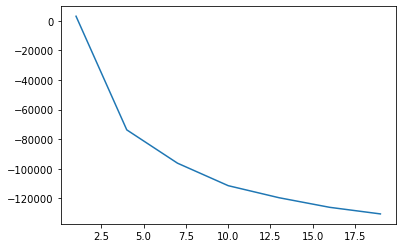

[True, True, True, True, True, True, True]


In [51]:
remodel, bic = bic_hmmlearn(X)

In [7]:
remodel = hmm.GaussianHMM(n_components=16, covariance_type="full", n_iter=100, init_params='stc',)
#remodel.means_ = np.array([[0.0], [0.5], [1]]) # ensure that our states are ordered low to high (e.g., 0=low, 1=mid...)
#remodel.fit(X)

print('model converged:', remodel.monitor_.converged)
Z2 = remodel.predict(X)
z2 = Z2.reshape((-1, len(clo_sel)))
z2.shape

model converged: False


NameError: name 'X' is not defined

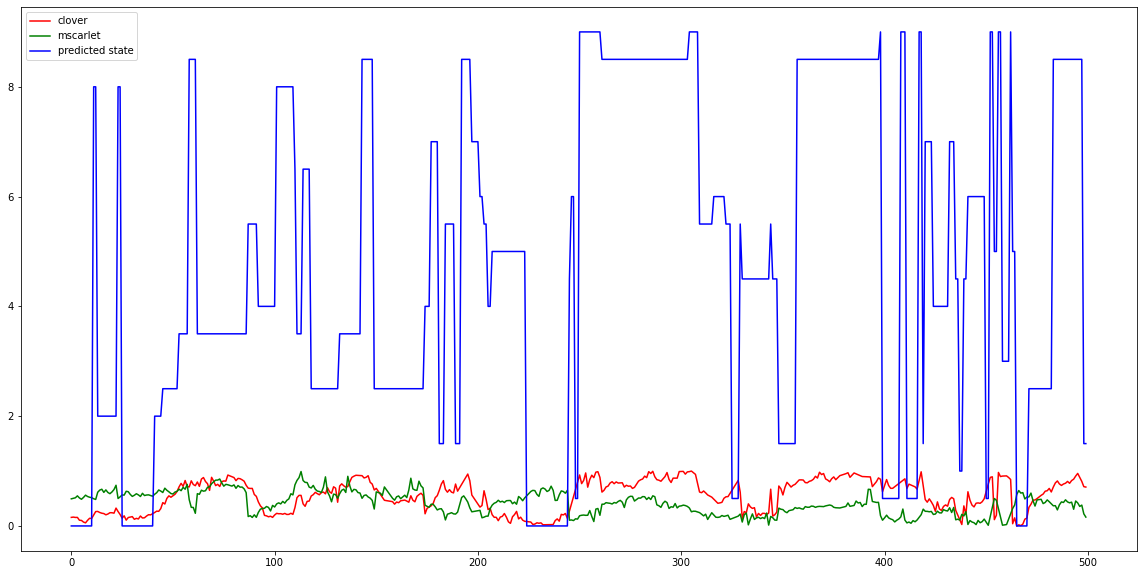

In [55]:
plt.figure(figsize=(20,10))
_n = 500
plt.plot(X[:_n, 0], 'r', label='clover')
plt.plot(X[:_n, 1], 'g', label='mscarlet')
plt.plot(Z2[:_n]/2, 'b', label='predicted state')
plt.legend()

plt.show()

In [56]:
res = pd.DataFrame(z2, columns=[x.split('_')[-1] for x in clo_sel])
res = res.assign(label=dat.track_index)
res = res.set_index('label').unstack().reset_index().rename({'level_0':'time', 0:'state'}, axis=1)
res.head()

,time,label,state
0,0.0,5_1000022195_heya8_cdk2_mdmx__untreated,0
1,0.0,86_1000214349_heya8_cdk2_mdmx__untreated,11
2,0.0,2_1000008156_heya8_cdk2_mdmx__untreated,8
3,0.0,79_1000179546_heya8_cdk2_mdmx__untreated,17
4,0.0,2_1000007033_heya8_cdk2_mdmx__untreated,3


In [57]:
out = res.groupby(['label','state']).count().rename({'time':'count'},axis=1).reset_index().set_index('label').pivot(columns='state', values='count').reset_index()
out = out.fillna(0)
out = out.assign(cell__treatment= [x.split('_', 2)[-1] for x in out.label])
#out = out.merge(dat[['track_index', 'cell__treatment']], left_on='label', right_on='track_index')
out = out.rename({x:f'state_{x}' for x in out.columns[1:-1]}, axis=1)
state_sel = out.columns[2:-1]
out.head()

state,label,state_0,state_1,state_2,state_3,state_4,state_5,state_6,state_7,state_8,...,state_10,state_11,state_12,state_13,state_14,state_15,state_16,state_17,state_18,cell__treatment
0,100_1000249955_heya8_cdk2_mdmx__bmn673+trametinib,30.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,21.0,0.0,32.0,0.0,0.0,heya8_cdk2_mdmx__bmn673+trametinib
1,101_1000251595_heya8_cdk2_mdmx__bmn673+trametinib,0.0,0.0,0.0,0.0,30.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,45.0,0.0,0.0,3.0,0.0,0.0,heya8_cdk2_mdmx__bmn673+trametinib
2,101_1000252386_heya8_cdk2_mdmx__bmn673+trametinib,0.0,0.0,0.0,0.0,0.0,34.0,0.0,0.0,0.0,...,0.0,5.0,5.0,0.0,43.0,0.0,0.0,0.0,0.0,heya8_cdk2_mdmx__bmn673+trametinib
3,102_1000253233_heya8_cdk2_mdmx__bmn673+trametinib,10.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,18.0,...,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,heya8_cdk2_mdmx__bmn673+trametinib
4,102_1000253498_heya8_cdk2_mdmx__bmn673+trametinib,0.0,0.0,0.0,0.0,41.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,41.0,0.0,0.0,0.0,heya8_cdk2_mdmx__bmn673+trametinib


In [59]:
tot = out.groupby(['cell__treatment'])['label'].count().reset_index()
cnts = out.groupby('cell__treatment').sum().reset_index()
norm_cnts = pd.DataFrame((cnts[state_sel].values.T/tot.label.values).T/87, columns=state_sel).assign(cell__treatment=cnts.cell__treatment)

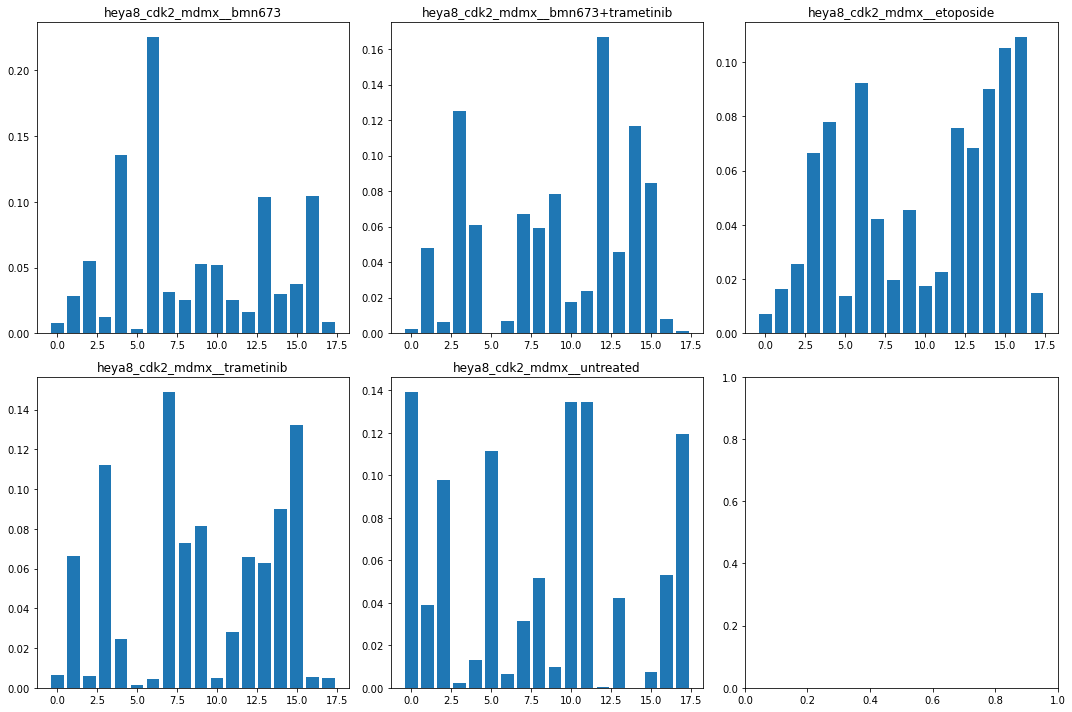

In [60]:
f, axes = plt.subplots(2,3, figsize=(15,10))
for i, row in norm_cnts.iterrows():
    x = row[state_sel].values
    axes.flat[i].bar(x=range(len(x)), height=x, label=row['cell__treatment'])
    axes.flat[i].set_title(row['cell__treatment'])
    
plt.tight_layout()
plt.show()

In [61]:
viz = norm_cnts.set_index('cell__treatment').unstack().reset_index().rename({0:'prob'}, axis=1)
viz.head()

,state,cell__treatment,prob
0,state_1,heya8_cdk2_mdmx__bmn673,0.007807
1,state_1,heya8_cdk2_mdmx__bmn673+trametinib,0.002189
2,state_1,heya8_cdk2_mdmx__etoposide,0.007184
3,state_1,heya8_cdk2_mdmx__trametinib,0.006466
4,state_1,heya8_cdk2_mdmx__untreated,0.139376


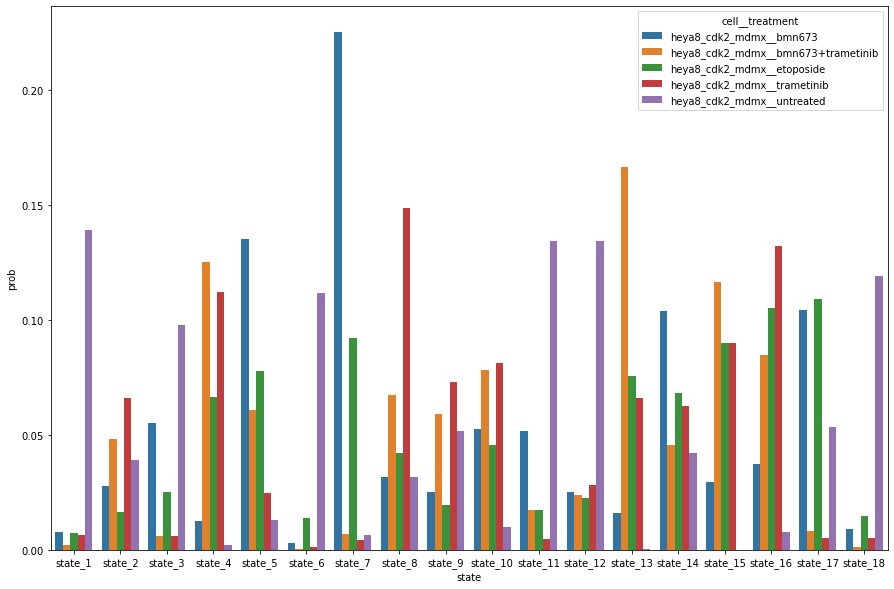

In [62]:
plt.figure(figsize=(15,10))
sbn.barplot(x='state', y='prob', hue='cell__treatment', data=viz)
plt.show()

# Which states are most common overall? 

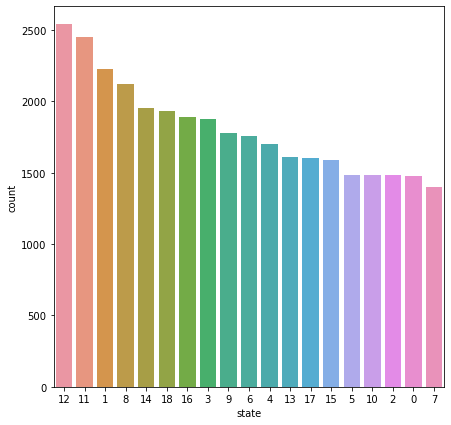

In [67]:
plt.figure(figsize=(7,7))
sbn.countplot(x='state', data=res, order=res.state.value_counts().index)
plt.show()

# Umap representation

In [75]:
reducer = umap.UMAP()
embed = reducer.fit_transform(out[state_sel].values)

In [76]:
out = out.assign(z1=embed[:,0], z2=embed[:,1])

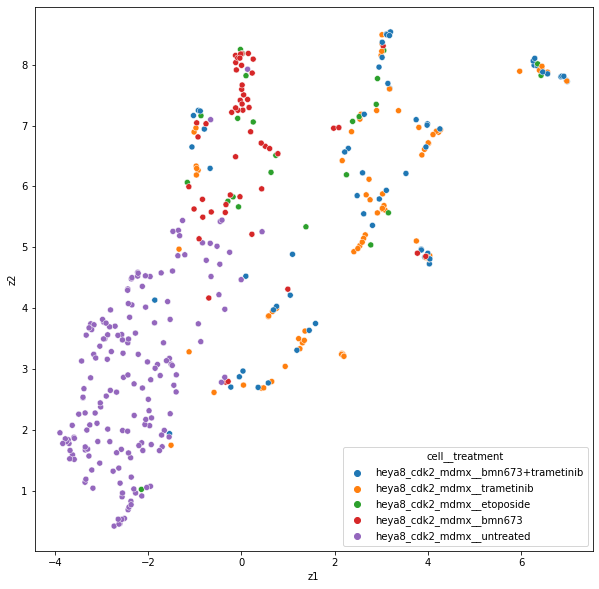

In [77]:
plt.figure(figsize=(10,10))
sbn.scatterplot(x='z1', y='z2', hue='cell__treatment', data=out)
plt.show()

# What does each state look like?

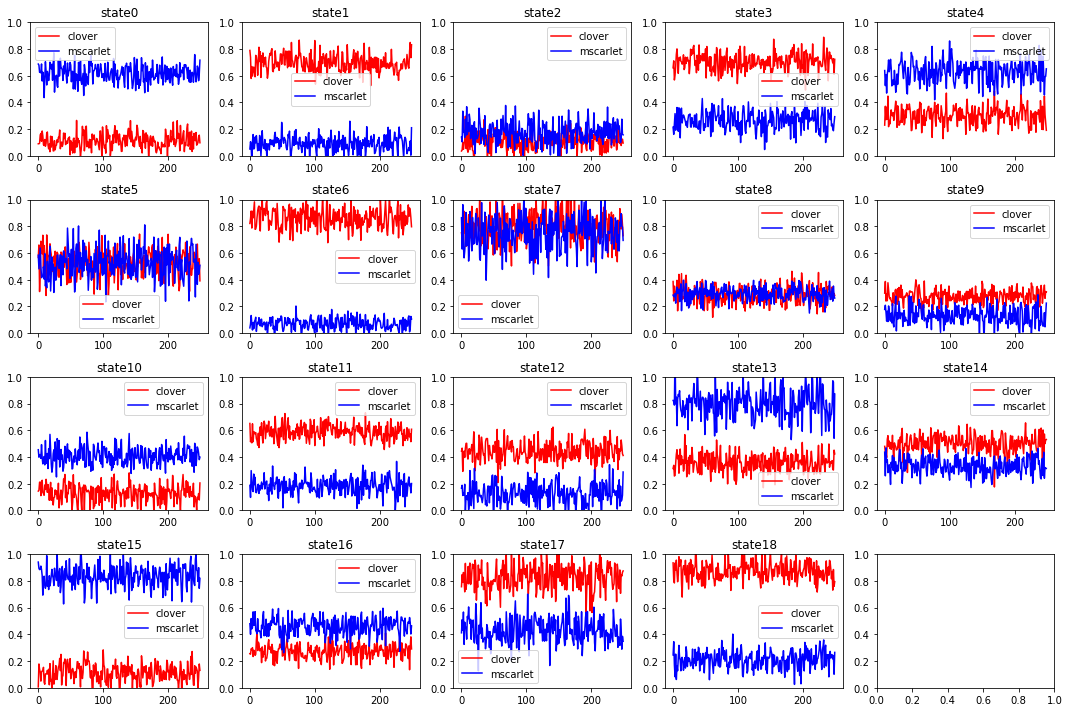

In [78]:
f, axes = plt.subplots(4,5, figsize=(15,10))
for i in range(remodel.n_components): 
    x = np.array([remodel._generate_sample_from_state(i) for x in range(250)])
    axes.flat[i].plot(x[:,0], 'r-', label='clover')
    axes.flat[i].plot(x[:, 1], 'b-', label='mscarlet')
    axes.flat[i].set_title('state' + str(i))
    axes.flat[i].set_ylim((0,1))
    axes.flat[i].legend()
plt.tight_layout()
plt.show()

# State transition matrix 

Which states do they jump between most commonly? 

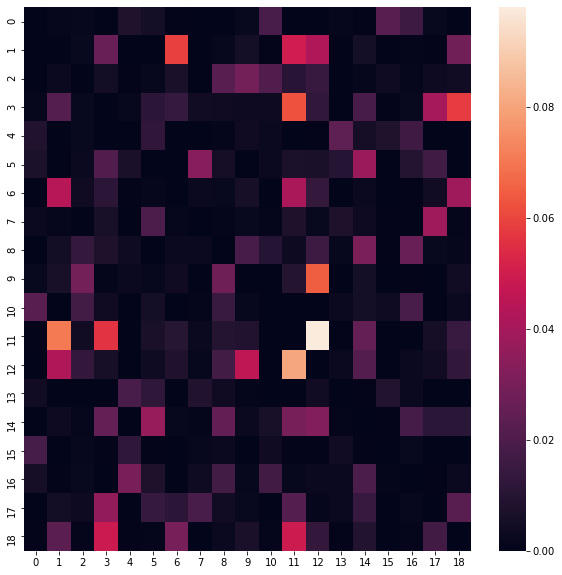

In [79]:
# have to set the diagonal to zero for decent viz (diag is much larger then off diag)
transition_mat = remodel.transmat_
np.fill_diagonal(transition_mat, 0) #acts *in-place* 

plt.figure(figsize=(10,10))
sbn.heatmap(transition_mat)
plt.show()

# State Co-variance matrix 

I was curious if any states had co-variance (off diagonal terms - which might indicate correlation between pathway activity)

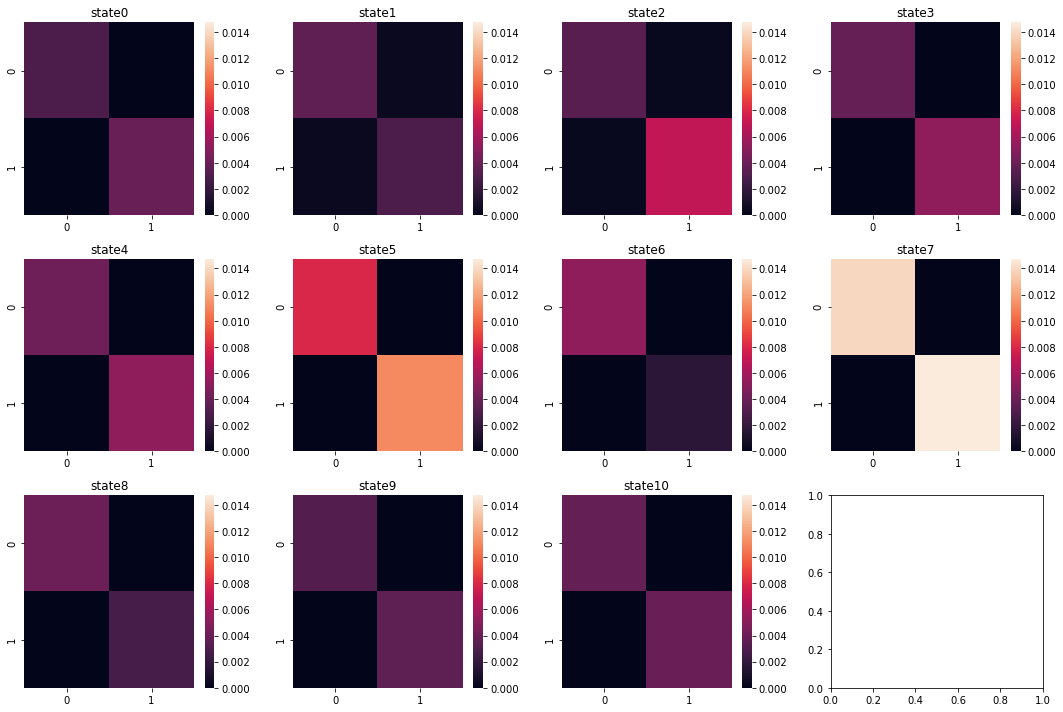

In [80]:
remodel.covars_

f, axes = plt.subplots(3,4, figsize=(15,10))
for i in range(11): 
    x = remodel.covars_[i, :, :]
    sbn.heatmap(x, ax=axes.flat[i], vmin=0, vmax=max(remodel.covars_.flatten()))
    axes.flat[i].set_title('state' + str(i))
plt.tight_layout()
plt.show()

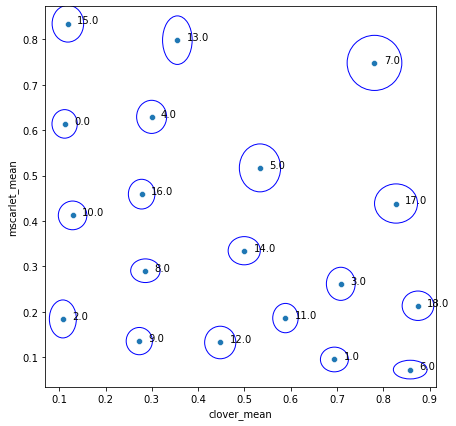

In [82]:
## TODO: add arrow sizes with thickness mediated by transition probabilities. 
## TODO: look at label specific transition probabilities/rates - does this change significnatly??? e.g. do they have different path changes? 


df = pd.DataFrame(remodel.means_, columns=['clover_mean', 'mscarlet_mean']).assign(state=range(remodel.means_.shape[0]))

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
    
def circle_point(x, y, var_x, var_y, ax):
    a = pd.concat({'x': x, 'y': y, 'var_x': var_x, 'var_y':var_y}, axis=1)
    for i, point in a.iterrows():
        elps = Ellipse((point.x, point.y), point.var_x**0.5, point.var_y**0.5, edgecolor='b',facecolor='none')
        ax.add_artist(elps)
        


plt.figure(figsize=(7,7))
sbn.scatterplot(x='clover_mean', y='mscarlet_mean', data=df)       
label_point(df.clover_mean, df.mscarlet_mean, df.state, plt.gca())
circle_point(df.clover_mean, df.mscarlet_mean, pd.Series(remodel.covars_[:,0, 0]), pd.Series(remodel.covars_[:,1, 1]), plt.gca())
plt.show()

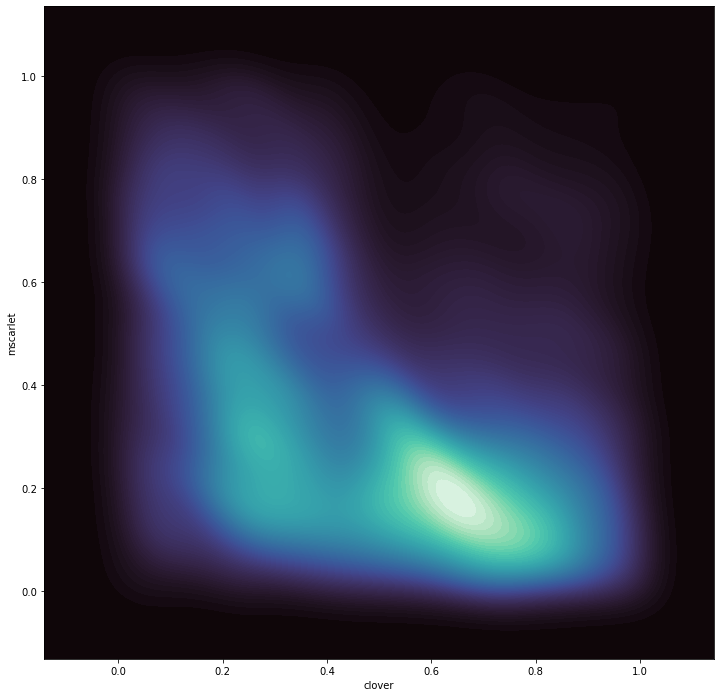

In [35]:
# does this orginization correllate to density of time series points? 
plt.figure(figsize=(12,12))
df2 = pd.DataFrame(X, columns=['clover', 'mscarlet'])
sbn.kdeplot(
    data=df2, x="clover", y="mscarlet",
    fill=True, thresh=0, levels=100, cmap="mako",
)
plt.show()